In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
from particles import resampling as rs
import sys
sys.path.append('..')

import banana as algo
importlib.reload(algo)

<module 'banana' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Banana/banana.py'>

In [2]:
d = 2
sigma = np.sqrt(2)

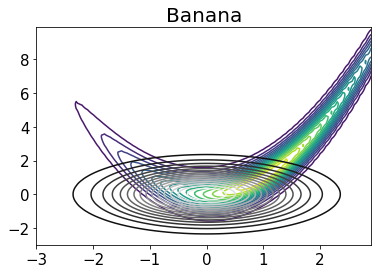

In [3]:
x, y = np.mgrid[-3:3:.1, -3:10:.1]
data = np.dstack((x, y))
z = np.exp(-(sigma**2*(data[:,:, 1]-data[:,:, 0]**2)**2/2+(1-data[:,:, 0])**2/(2*sigma**2)))/(2*np.pi)
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
plt.contour(x, y, z, 15)
plt.contour(x, y, zinitial, 15, cmap = 'gray')
plt.title('Banana', fontsize = 20)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig("banana.pdf")

## Algorithms

In [4]:
Niter = 3000
gamma = 0.01
N = 300
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

nmcmc = 1

In [5]:
true_sample = np.zeros((N, d))
true_sample[:, 0] = np.random.normal(loc = 1, scale = sigma, size = N)
true_sample[:, 1] = np.random.normal(loc = true_sample[:, 0]**2, scale = 1/sigma, size = N)

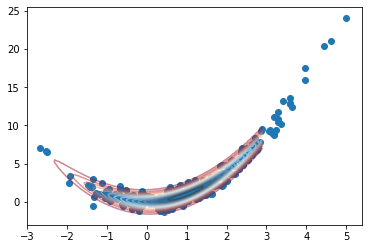

In [6]:
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(true_sample[:,0], true_sample[:,1]);

In [7]:
true_cov = np.cov(true_sample, rowvar = False)

In [8]:
Niter_ula = Niter
Niter_mala = Niter
Niter_fr = Niter
Niter_smcula = Niter
Niter_smcmala = Niter

In [9]:
gamma_mala = 0.12
gamma_smcmala = 0.12

In [10]:
Nalgo = 6
Nrep = 1

runtime = np.zeros((Nrep, Nalgo))

In [11]:
w1_ula = np.zeros((Nrep, Niter_ula, d))
w1_mala = np.zeros((Nrep, Niter_mala, d))
w1_fr = np.zeros((Nrep, Niter_fr, d))
w1_wfr = np.zeros((Nrep, Niter, d))
w1_smcula = np.zeros((Nrep, Niter_smcula, d))
w1_smcmala = np.zeros((Nrep, Niter_smcmala, d))

cov_ula = np.zeros((Nrep, Niter_ula))
cov_mala = np.zeros((Nrep, Niter_mala))
cov_fr = np.zeros((Nrep, Niter_fr))
cov_wfr = np.zeros((Nrep, Niter))
cov_smcula = np.zeros((Nrep, Niter_smcula))
cov_smcmala = np.zeros((Nrep, Niter_smcmala))

In [12]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain, w1_ula[i,:], cov_ula[i,:] = algo.ParallelULA(gamma, Niter_ula, X0, sigma, true_sample.T, true_cov)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain, accepted_mala, w1_mala[i,:], cov_mala[i,:] = algo.ParallelMALA(gamma_mala, Niter_mala, X0, sigma, true_sample.T, true_cov)
    end = time.time()
    runtime[i, 1] = end-start
    ## SMC-FR
    start = time.time()
    fr_x, fr_w, w1_fr[i,:], cov_fr[i,:] = algo.SMC_FR(gamma, Niter_fr, X0, sigma, true_sample.T, true_cov, 1)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x, wfr_w, w1_wfr[i,:], cov_wfr[i,:] = algo.SMC_WFR(gamma, Niter, X0, sigma, true_sample.T, true_cov, nmcmc)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x, smcula_w, w1_smcula[i,:], cov_smcula[i,:] = algo.SMC_ULA(gamma, Niter_smcula, X0, sigma, true_sample.T, true_cov, nmcmc)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x, smcmala_w, accepted_smcmala, w1_smcmala[i,:], cov_smcmala[i,:] = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, X0, sigma, true_sample.T, true_cov, 1)
    end = time.time()
    runtime[i, 5] = end-start

In [13]:
np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

0.5678922222222222

In [14]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.5598377777777777

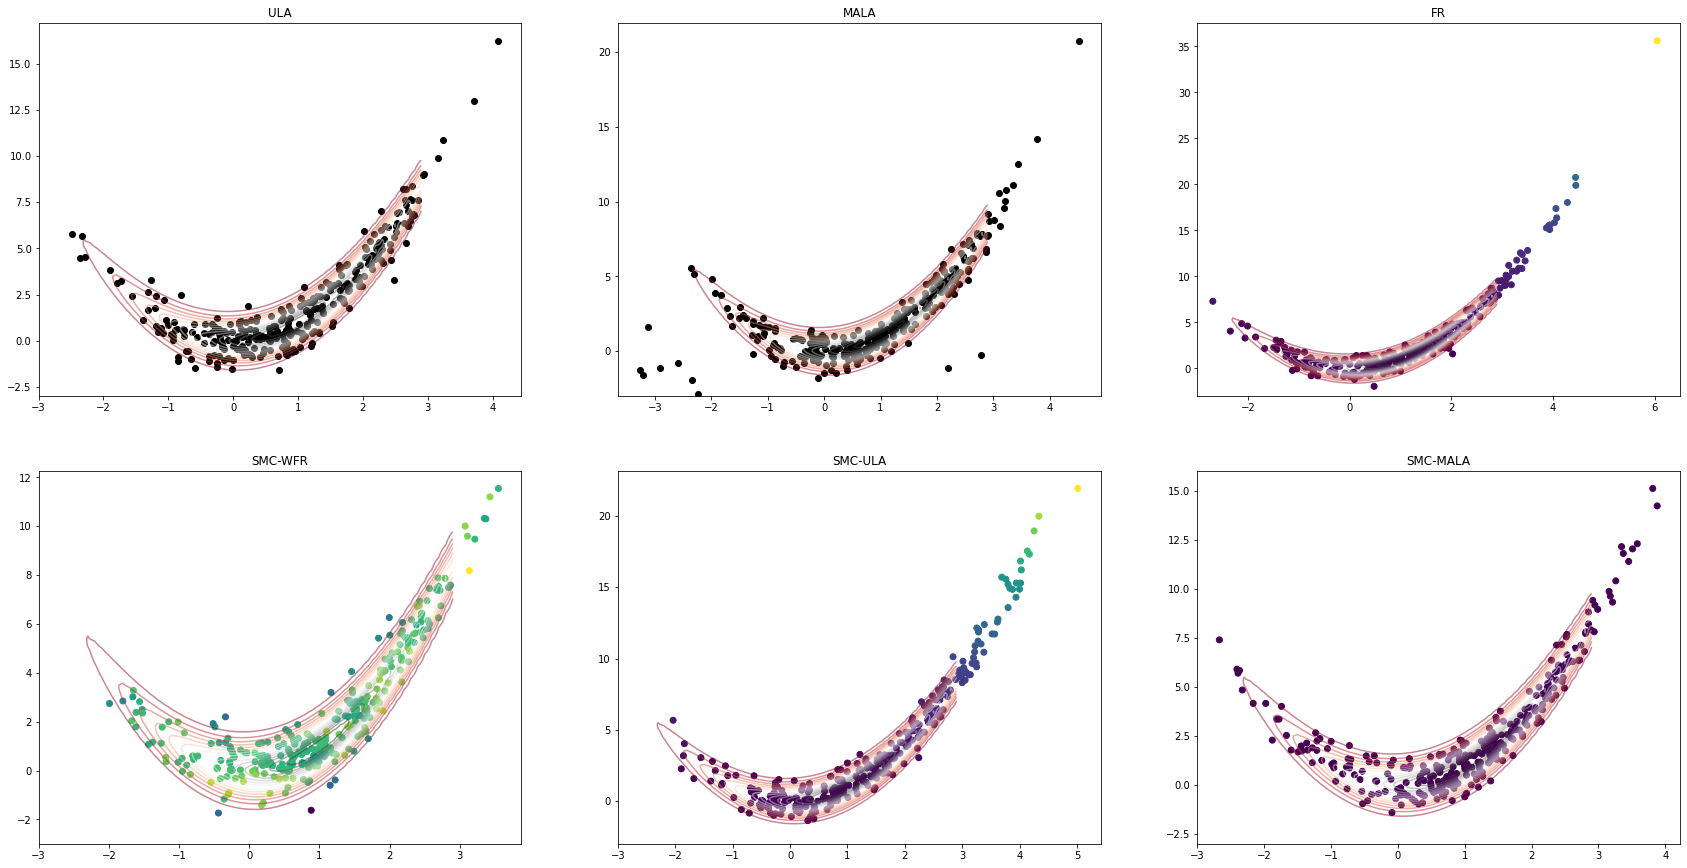

In [15]:
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 3, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[0, :], ula_chain[1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(mala_chain[0, :], mala_chain[1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[0, :], fr_x[1, :], c = fr_w);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[0, :], wfr_x[1, :], c = wfr_w);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[0, :], smcula_x[1, :], c = smcula_w);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[0, :], smcmala_x[1, :], c = smcmala_w);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [16]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime

array([1.24870205, 2.45543909, 2.67889595, 4.80377388, 1.37814498,
       2.70321298])

In [17]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [19]:
w1_ula_plot = np.mean(np.mean(w1_ula, axis = 0), axis = 1)
w1_mala_plot = np.mean(np.mean(w1_mala, axis = 0), axis = 1)
w1_fr_plot = np.mean(np.mean(w1_fr, axis = 0), axis = 1)
w1_wfr_plot = np.mean(np.mean(w1_wfr, axis = 0), axis = 1)
w1_smcula_plot = np.mean(np.mean(w1_smcula, axis = 0), axis = 1)
w1_smcmala_plot = np.mean(np.mean(w1_smcmala, axis = 0), axis = 1)

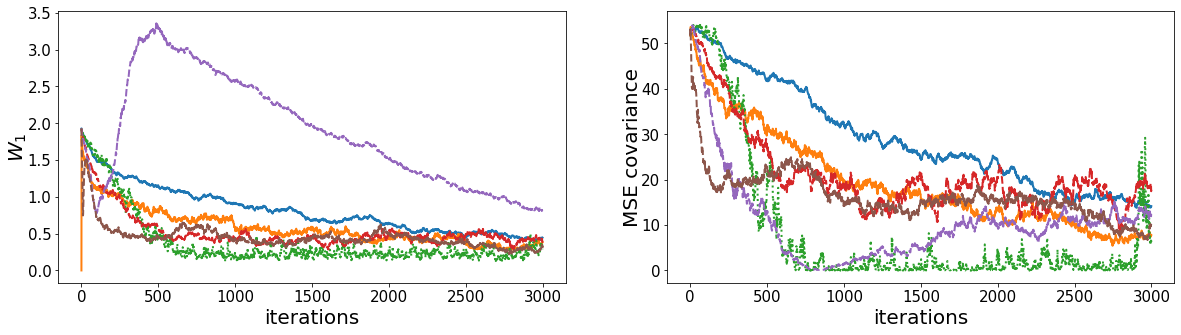

In [20]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(w1_ula_plot, label = 'ULA', lw = 2, c = colors[0])
plt.plot(w1_mala_plot, label = 'MALA', lw = 2, c = colors[1])
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.plot(np.mean(cov_ula, axis = 0), lw = 2, c = colors[0])
plt.plot(np.mean(cov_mala, axis = 0), lw = 2, c = colors[1])
plt.plot(np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('banana_iter.pdf', bbox_inches="tight")

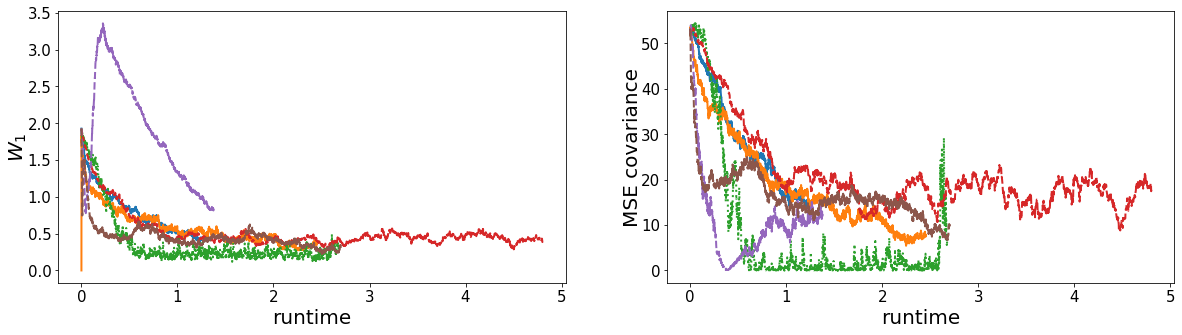

In [21]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(xx_ula, w1_ula_plot, label = 'ULA', lw = 2, c = colors[0])
plt.plot(xx_mala, w1_mala_plot, label = 'MALA', lw = 2, c = colors[1])
plt.plot(xx_fr, w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(xx_wfr, w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(xx_smcula, w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(xx_smcmala, w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.plot(xx_ula, np.mean(cov_ula, axis = 0), lw = 2, c = colors[0])
plt.plot(xx_mala, np.mean(cov_mala, axis = 0), lw = 2, c = colors[1])
plt.plot(xx_fr, np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(xx_wfr, np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(xx_smcula, np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(xx_smcmala, np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('banana_runtime.pdf', bbox_inches="tight")